##  EDA For Credit Card Fraud Detection

### 1) Setup & Imports
- Load required libraries used throughout the notebook.
- Keep everything in one place for reproducibility.


In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
from scipy.stats import ttest_ind
from scipy import stats

#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC

In [4]:
# This function is used to calculate the shortest distance between two points on the Earth's surface, taking into account the Earth's ellipsoidal shape.
#from geopy.distance import geodesic 

### 2) Load the Dataset
- Read the credit card transactions dataset.
- Create the main dataframe data.


In [5]:
# load the data 
data = pd.read_csv("Data_wrangle_credit_card_fraudv1.csv")

### 3) Basic Data Checks
Quick sanity checks to understand the dataset size, columns, and initial quality.


In [6]:
data.shape

(1852394, 29)

In [7]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.011293,-82.048315,0,2019,1,1,0,0,31,adult
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,49.159047,-118.186462,0,2019,1,1,0,0,41,adult
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,43.150704,-112.154481,0,2019,1,1,0,0,57,senior
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,47.034331,-112.561071,0,2019,1,1,0,1,52,senior
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.674999,-78.632459,0,2019,1,1,0,3,33,adult


### 4) Date/Time Feature Engineering
- Extract useful time features from transaction timestamp.
- Drop raw timestamp after extracting needed information.


In [8]:
# extracted day of week from 'trans_date_trans_time'
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['tr_day'] = data['trans_date_trans_time'].dt.dayofweek
data['tr_day_name'] = data['tr_day'].map(dict(enumerate(calendar.day_name)))

In [9]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name'],
      dtype='object')

In [10]:
# droped 'trans_date_trans_time' because already calculated age and extracted tr_hr,tr_year,tr_month etc 
#data = data.drop(columns = ['trans_date_trans_time'])


In [11]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,2019,1,1,0,0,31,adult,Tuesday
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,0,2019,1,1,0,0,41,adult,Tuesday
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.154481,0,2019,1,1,0,0,57,senior,Tuesday
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.561071,0,2019,1,1,0,1,52,senior,Tuesday
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-78.632459,0,2019,1,1,0,3,33,adult,Tuesday


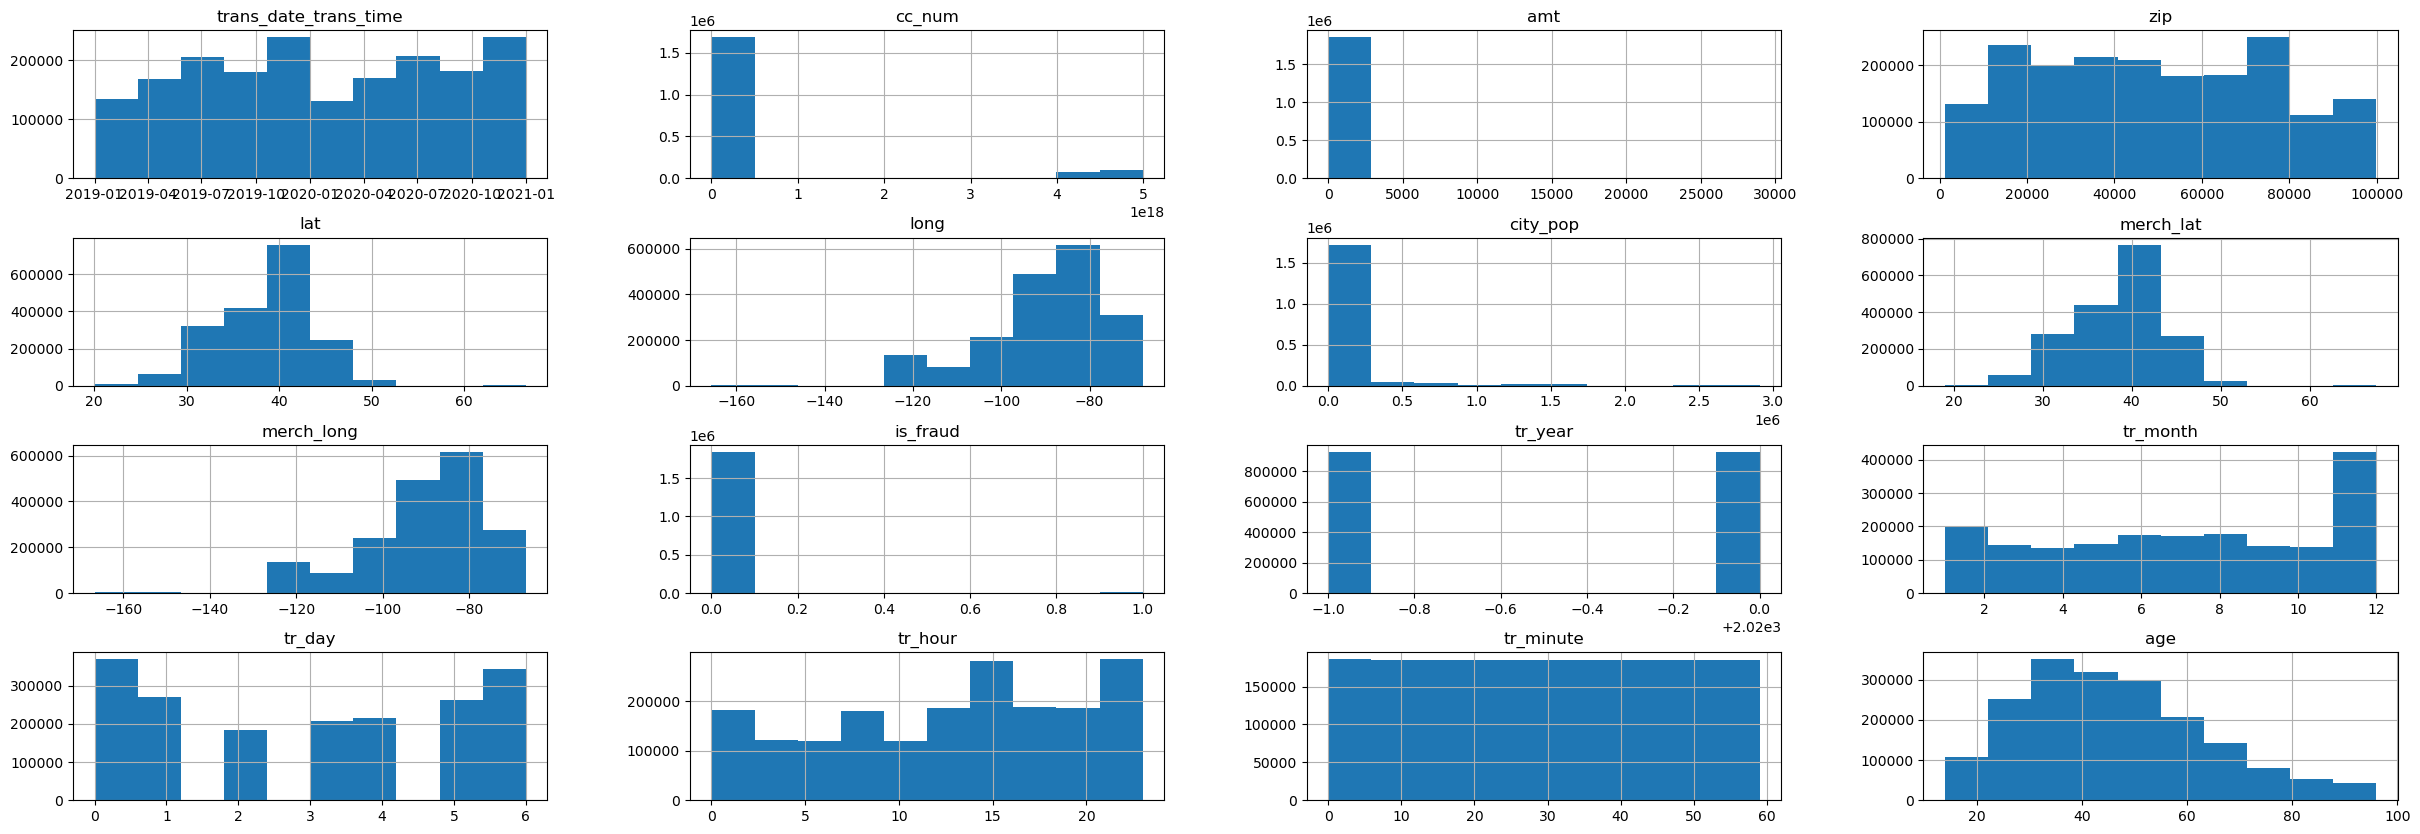

In [12]:
# histogram for all numerical features
data.hist(figsize=(30,10))
plt.subplots_adjust(hspace=0.4);

From above histogram we can analyse, Transaction amount (amt) is right-skewed,Majority of transactions are low value.ZIP codes are widely spread,Confirms diverse customer base,Age is roughly bell-shaped Most customers fall in working-age group.Hour-wise variation exists,Some hours have higher transaction frequency.

### 5) Target Variable Distribution (Class Imbalance)
Fraud datasets are highly imbalanced. This section checks the class distribution and fraud percentage.


In [13]:
# target feature value_counts
data['is_fraud'].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [14]:
# percentage of fraud in dataset i.e. 0.52% .
fraud_percent = (data['is_fraud'].sum())/len(data) * 100
print(f'farud percent is {fraud_percent:.2f}%')

farud percent is 0.52%


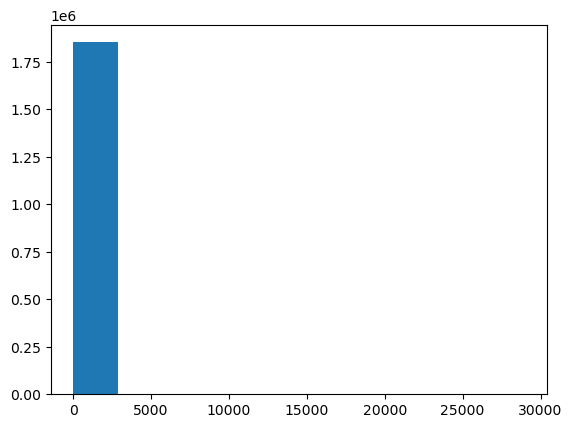

In [15]:
# histogram of amount feature
plt.hist(data['amt']) # use log scle for right or left skewed plot by using logerithmic scale we can easily interpret the data
plt.show()

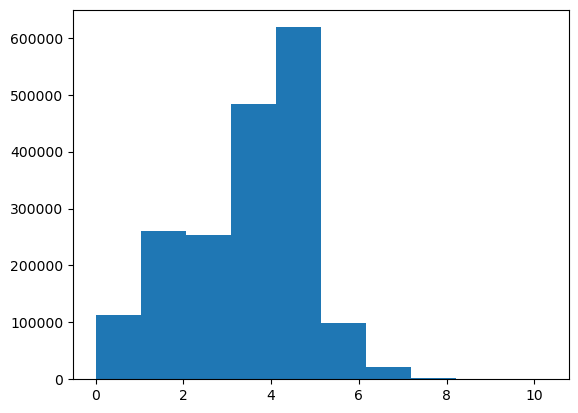

In [16]:
# histogram of amount on logerithmic scale 
plt.hist(np.log(data['amt'])) # use log scle for right or left skewed plot by using logerithmic scale we can easily interpret the data
plt.show() # X axis x=2→≈7.4, x=4→≈54.6, x=5→≈148, x=6→≈403, x=7→≈1,096, x=8→≈2,981, x=9→≈8,103, x=10→≈22,026

In [17]:
data['amt'].describe()

count    1.852394e+06
mean     7.006357e+01
std      1.592540e+02
min      1.000000e+00
25%      9.640000e+00
50%      4.745000e+01
75%      8.310000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [18]:
# Removed outliers from amount column and added new column amt_clean??????
# we can not remove oulier here because amount is main column so we do capping during preprocessing preprocessing 
# Q1 = data['amt'].quantile(0.25)
# Q3 = data['amt'].quantile(0.75)
# IQR = Q3 - Q1
# low_lim  = Q1 - 1.5 * IQR
# upper_lim = Q3 + 1.5 * IQR

# data['amt_clean'] = data.loc[(data['amt']>low_lim) & (data['amt'] < upper_lim),'amt']
# data.head()

In [19]:
#data.loc[data['is_fraud']==1,'amt_clean'].isna().value_counts()
# it means all fraud amount values are ouliers

### 6) Amount Outlier Handling
Outlier analysis on transaction amount to understand extreme values and their relationship with fraud.


In [20]:
# outliers in amount columns
Q1 = data['amt'].quantile(0.25)
Q3 = data['amt'].quantile(0.75)
IQR = Q3 - Q1
low_lim  = Q1 - 1.5*IQR
upper_lim = Q3 + 1.5*IQR

# All outliers: amt < low_lim OR amt > upper_lim
data['outliers_amount'] = data.loc[(data['amt'] < low_lim) | (data['amt'] > upper_lim), 'amt']


In [21]:
data['outliers_amount'].value_counts()

outliers_amount
200.79     22
196.16     22
195.20     22
200.73     21
195.01     21
           ..
307.99      1
259.84      1
2168.91     1
344.59      1
459.40      1
Name: count, Length: 41386, dtype: int64

In [22]:
# group by'merchant', 'is_fraud' on outlier amount and analysed merchant wise count of 'outliers_amount
# count merchant who has highest 'outliers_amount'

data.groupby(['merchant', 'is_fraud'])['outliers_amount'].count().sort_values(ascending=False).head(10)

merchant                           is_fraud
fraud_Boyer PLC                    0           429
fraud_Kilback LLC                  0           403
fraud_Bauch-Raynor                 0           383
fraud_Murray-Smitham               0           382
fraud_Kuhn LLC                     0           381
fraud_Schultz, Simonis and Little  0           380
fraud_Pacocha-O'Reilly             0           379
fraud_DuBuque LLC                  0           379
fraud_Goodwin-Nitzsche             0           378
fraud_Hudson-Ratke                 0           378
Name: outliers_amount, dtype: int64

In [23]:
# group by'merchant', 'is_fraud' on outlier amount and analysed which merchant wise sum of 'outliers_amount
# calculated sum of 'outliers_amount' for each merchant 
data.groupby(['merchant', 'is_fraud'])['outliers_amount'].sum().sort_values(ascending=False).head(10)

merchant                             is_fraud
fraud_Boyer PLC                      0           198732.00
fraud_Gislason Group                 0           194820.18
fraud_Kuhn LLC                       0           189567.88
fraud_Boyer-Haley                    0           183987.22
fraud_Pacocha-Bauch                  0           179657.05
fraud_Pfeffer and Sons               0           176096.55
fraud_Haley, Jewess and Bechtelar    0           169628.03
fraud_Lesch Ltd                      0           168745.27
fraud_Jewess LLC                     0           166569.84
fraud_Douglas, Schneider and Turner  0           166054.62
Name: outliers_amount, dtype: float64

In [24]:
# group by'merchant', 'is_fraud'  on 'outliers_amount' and analysed for city wise sum of 'outliers_amount
data.groupby(['city', 'is_fraud'])['outliers_amount'].sum().sort_values(ascending=False).head(10)

city          is_fraud
Meridian      0           278979.36
Brandon       0           227335.60
Houston       0           207428.48
Phoenix       0           203845.08
Philadelphia  0           202396.87
Grandview     0           197515.71
Indianapolis  0           192541.59
Newhall       0           192210.89
Hinckley      0           189328.95
Manistique    0           184777.77
Name: outliers_amount, dtype: float64

In [25]:
# group by'category', 'is_fraud' on 'outliers_amount' and analysed category wise sum of 'outliers_amount
data.groupby(['category', 'is_fraud'])['outliers_amount'].sum().sort_values(ascending=False).head(10)

category       is_fraud
shopping_pos   0           7484583.24
shopping_net   0           6283948.53
travel         0           6129573.08
misc_pos       0           3867015.17
grocery_pos    0           3782133.52
misc_net       0           3544377.98
shopping_net   1           2214847.64
entertainment  0           1479890.76
misc_net       1            944009.71
shopping_pos   1            928132.34
Name: outliers_amount, dtype: float64

(array([5.5999e+04, 1.9651e+04, 1.1075e+04, 6.2360e+03, 1.2870e+03,
        4.9100e+02, 1.9300e+02, 7.8000e+01, 3.5000e+01, 9.0000e+00]),
 array([ 5.26424339,  5.7651478 ,  6.26605221,  6.76695662,  7.26786103,
         7.76876544,  8.26966985,  8.77057426,  9.27147867,  9.77238308,
        10.27328749]),
 <BarContainer object of 10 artists>)

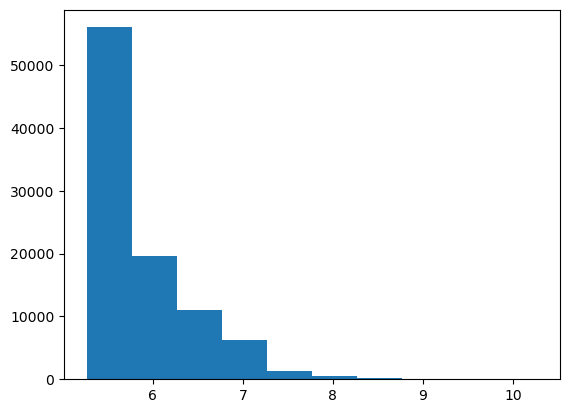

In [26]:
#X axis x=2→≈7.4, x=4→≈54.6, x=5→≈148, x=6→≈403, x=7→≈1,096, x=8→≈2,981, x=9→≈8,103, x=10→≈22,026
plt.hist(np.log(data['outliers_amount']))

In [27]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,outliers_amount
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,NaN
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,220.11
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,NaN


In [28]:
# converted dob and unixtime  into date_time formate to make it meaningful and to enable time based calculations
data['dob'] = pd.to_datetime(data['dob'])
data['unix_time'] = pd.to_datetime(data['unix_time'])
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name', 'outliers_amount'],
      dtype='object')

In [29]:
#extracted numerical feature from data set
numerical_feature = data.select_dtypes(include = 'number')
numerical_feature

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,outliers_amount
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,2019,1,1,0,0,31,NaN
1,630423337322,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,2019,1,1,0,0,41,NaN
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,2019,1,1,0,0,57,220.11
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,2019,1,1,0,1,52,NaN
4,375534208663984,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,2019,1,1,0,3,33,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,43.77,63453,40.4931,-91.8912,519,39.946837,-91.333331,0,2020,12,3,23,59,54,NaN
1852390,3556613125071656,111.84,77566,29.0393,-95.4401,28739,29.661049,-96.186633,0,2020,12,3,23,59,21,NaN
1852391,6011724471098086,86.88,99323,46.1966,-118.9017,3684,46.658340,-119.715054,0,2020,12,3,23,59,39,NaN
1852392,4079773899158,7.99,83643,44.6255,-116.4493,129,44.470525,-117.080888,0,2020,12,3,23,59,55,NaN


In [30]:
numerical_feature.columns

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'outliers_amount'],
      dtype='object')

In [31]:
# extracted categorical fetures from data set
categorical_feature = data.select_dtypes(include=['object', 'category'])
categorical_feature

,merchant,category,first,last,gender,street,city,state,job,trans_num,age_group,tr_day_name
0,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",0b242abb623afc578575680df30655b9,adult,Tuesday
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1f76529f8574734946361c461b024d99,adult,Tuesday
2,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,senior,Tuesday
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,6b849c168bdad6f867558c3793159a81,senior,Tuesday
4,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,adult,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,fraud_Reilly and Sons,health_fitness,Michael,Olson,M,558 Michael Estates,Luray,MO,Town planner,9b1f753c79894c9f4b71f04581835ada,senior,Thursday
1852390,fraud_Hoppe-Parisian,kids_pets,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,Futures trader,2090647dac2c89a1d86c514c427f5b91,adult,Thursday
1852391,fraud_Rau-Robel,kids_pets,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,Musician,6c5b7c8add471975aa0fec023b2e8408,adult,Thursday
1852392,fraud_Breitenberg LLC,travel,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,Cartographer,14392d723bb7737606b2700ac791b7aa,senior,Thursday


In [32]:
categorical_feature.columns

Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'trans_num', 'age_group', 'tr_day_name'],
      dtype='object')

### 7) Numerical Feature Analysis
Explore patterns and distributions in key numerical features (and their relation to fraud).


In [33]:
# found corelation between numerical features 
numerical_feature.corr()

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,outliers_amount
cc_num,1.000000,0.001826,0.041504,-0.058744,-0.048429,-0.009118,-0.058415,-0.048421,-0.001125,0.000443,-0.000188,-0.000851,-0.000902,0.000303,-0.000131,-0.004092
amt,0.001826,1.000000,0.001979,-0.000670,-0.000735,0.004921,-0.000613,-0.000711,0.209308,-0.001266,-0.002593,0.000491,-0.024891,0.000470,-0.010695,1.000000
zip,0.041504,0.001979,1.000000,-0.114554,-0.909795,0.077601,-0.113934,-0.908981,-0.002190,0.000522,0.001160,-0.001021,0.005947,0.000748,0.010359,-0.017359
lat,-0.058744,-0.000670,-0.114554,1.000000,-0.014744,-0.154816,0.993582,-0.014709,0.002904,0.001140,-0.000402,0.000637,-0.011259,-0.000404,0.047143,0.024274
long,-0.048429,-0.000735,-0.909795,-0.014744,1.000000,-0.052359,-0.014585,0.999118,0.001022,0.000012,-0.001184,0.001157,-0.002082,-0.000613,-0.029437,0.009109
city_pop,-0.009118,0.004921,0.077601,-0.154816,-0.052359,1.000000,-0.153863,-0.052329,0.000325,-0.001660,-0.000510,0.001180,0.019949,-0.000382,-0.090889,-0.025487
merch_lat,-0.058415,-0.000613,-0.113934,0.993582,-0.014585,-0.153863,1.000000,-0.014554,0.002778,0.001108,-0.000429,0.000505,-0.011119,-0.000435,0.046768,0.024256
merch_long,-0.048421,-0.000711,-0.908981,-0.014709,0.999118,-0.052329,-0.014554,1.000000,0.000999,0.000010,-0.001175,0.001122,-0.002120,-0.000637,-0.029392,0.009240
is_fraud,-0.001125,0.209308,-0.002190,0.002904,0.001022,0.000325,0.002778,0.000999,1.000000,-0.006022,-0.016417,0.004562,0.013196,0.000235,0.010927,0.132264
tr_year,0.000443,-0.001266,0.000522,0.001140,0.000012,-0.001660,0.001108,0.000010,-0.006022,1.000000,0.000730,-0.080235,-0.000329,0.000009,0.024121,-0.004476


<Axes: >

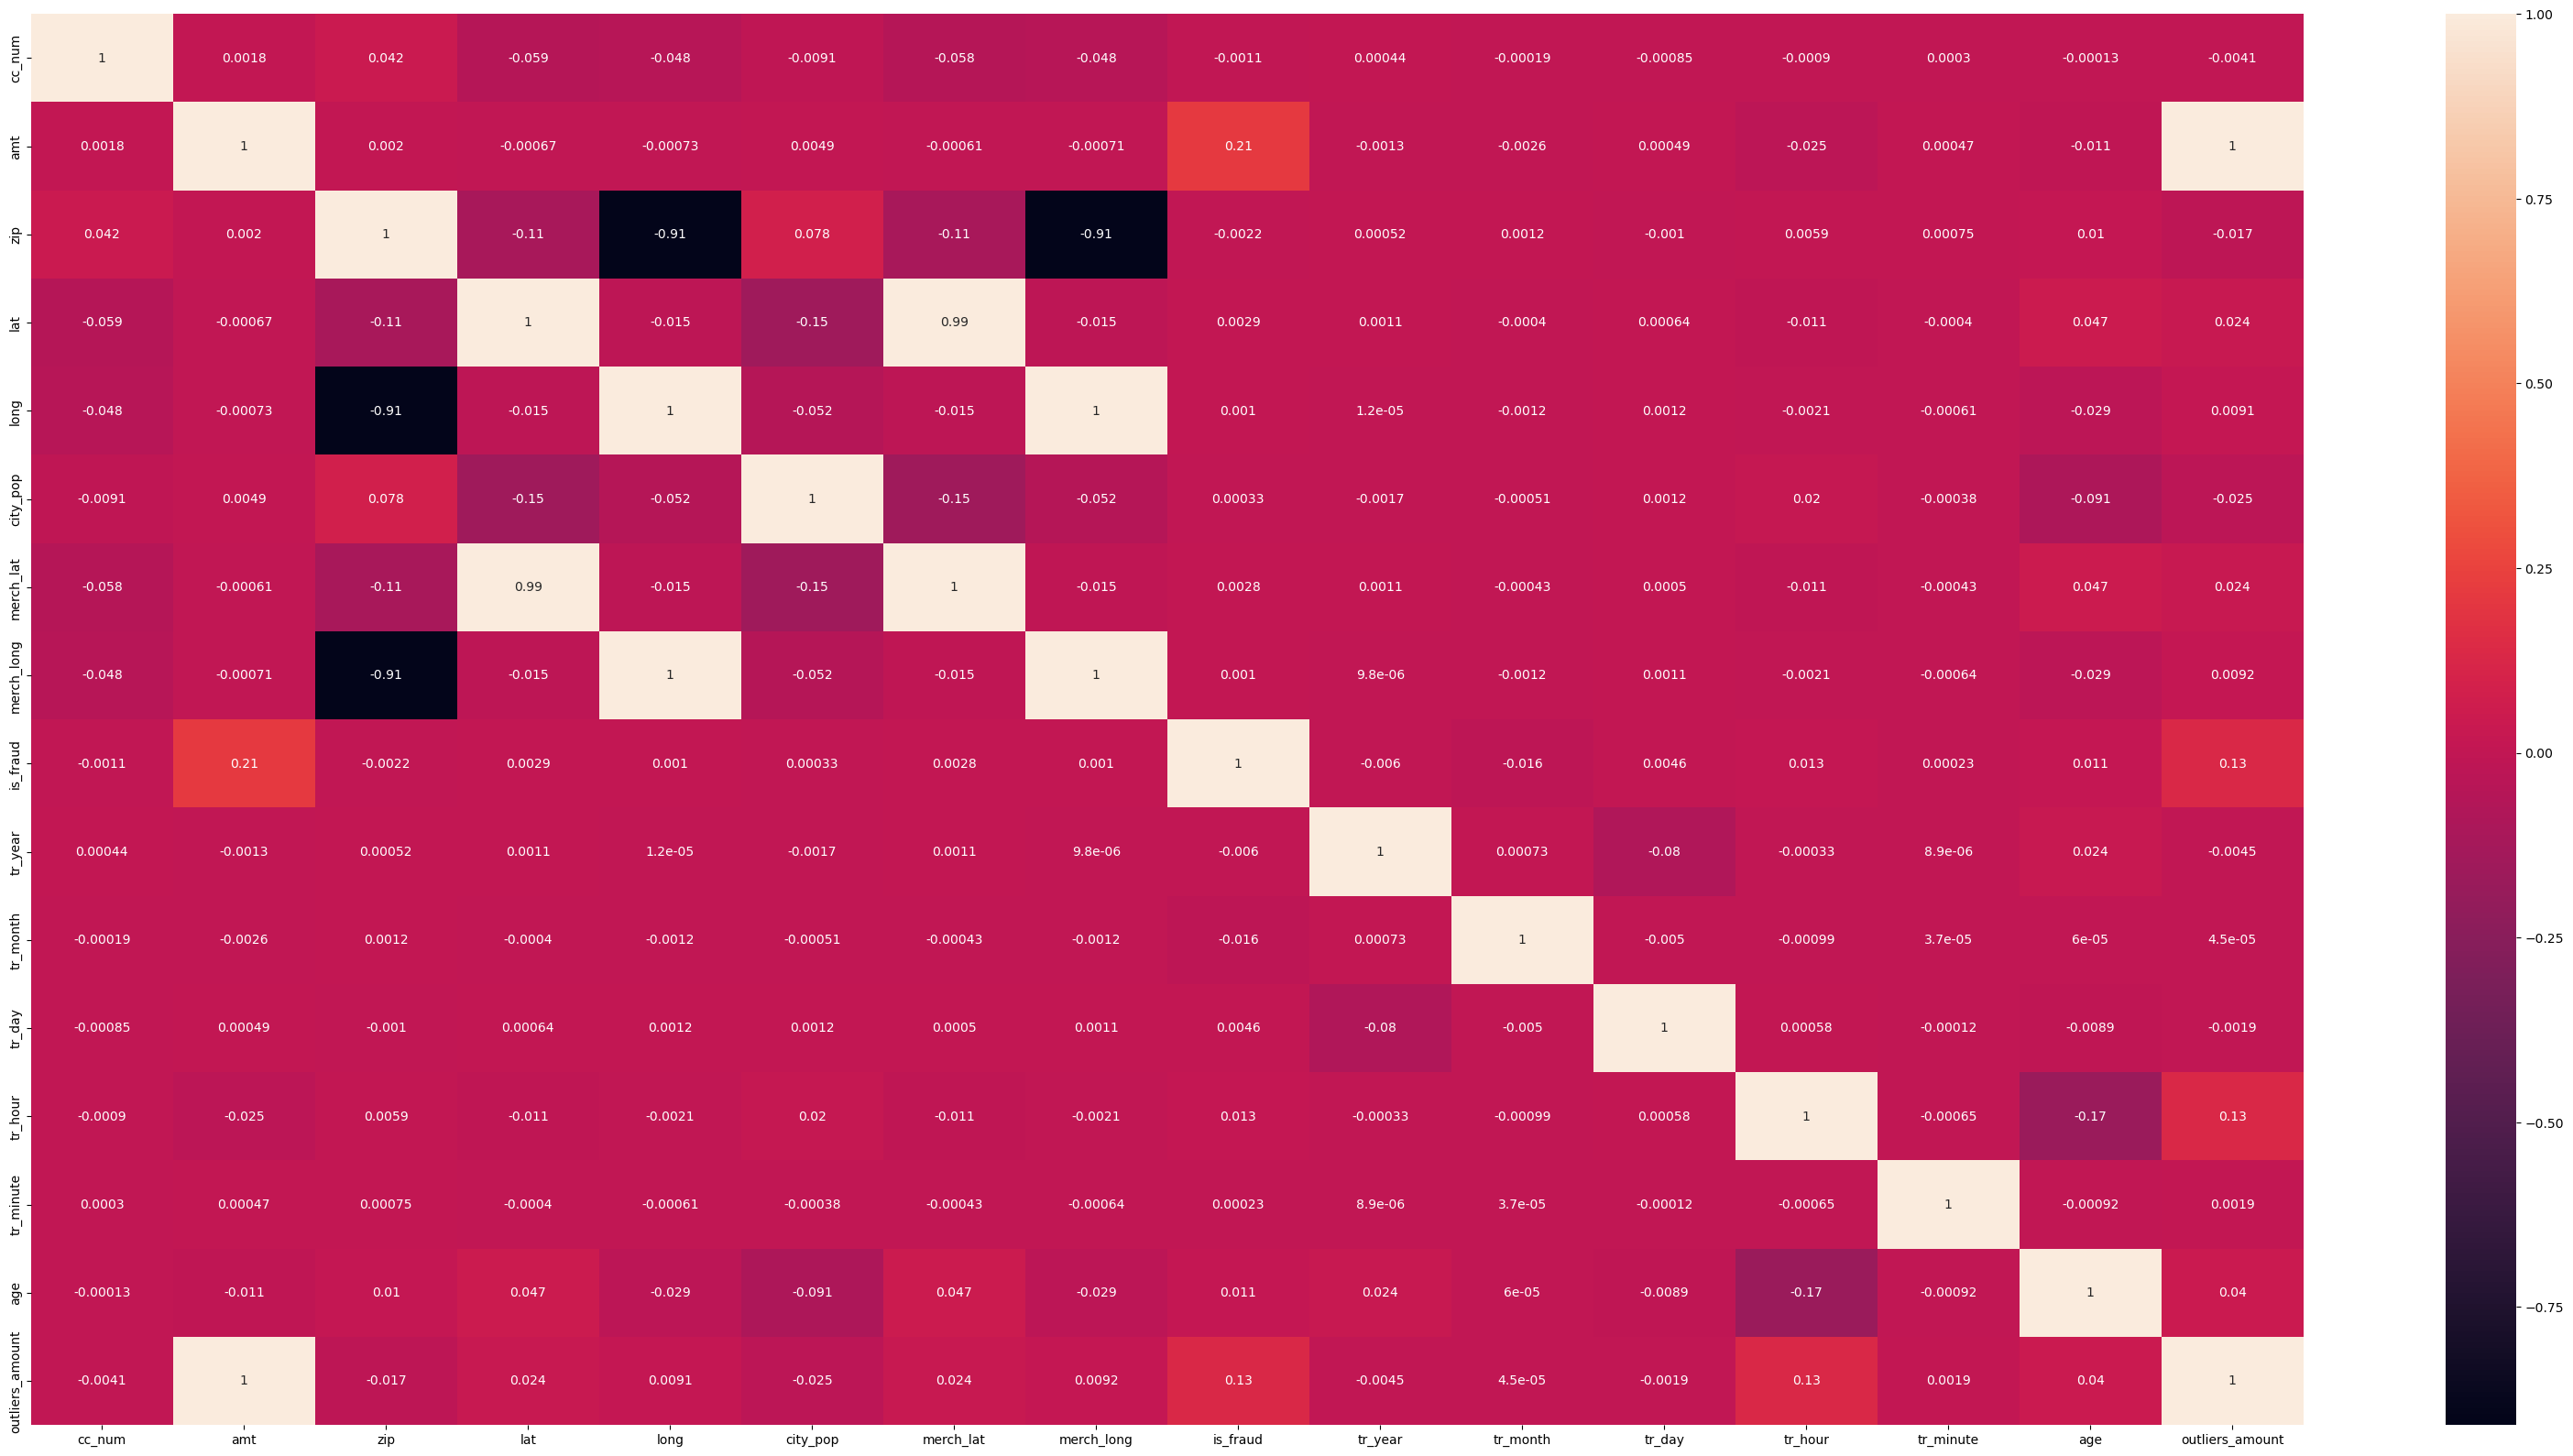

In [34]:
# plotted heatmap to visualize correlation between numerical features
plt.figure(figsize= (40,20))
sns.heatmap(numerical_feature.corr(), annot = True)

From heat map we can analyse that (lat and merch_lat),(long and merch_long) is highly positive corelated with each other, it means card holder resides near by merchant address.In addition amount and is_fruad is also positive co-related with each other and relation is weak positive relation.

In [35]:
# other option of geodesic is haversine because it is  100 time faster than geodesic.
# Vectorized Haversine distance between pairs of latitude/longitude points.
# If inputs are pandas Series, convert to NumPy and convert DEGREES -> RADIANS.
# np.radians is vectorized, so it efficiently handles whole arrays/Series

R_KM = 6371.0088  # mean Earth radius

def haversine_km(lat1, lon1, lat2, lon2):
    # inputs can be pandas Series; convert to numpy arrays
    lat1 = np.radians(lat1.to_numpy())
    lon1 = np.radians(lon1.to_numpy())
    lat2 = np.radians(lat2.to_numpy())
    lon2 = np.radians(lon2.to_numpy())

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return 2 * R_KM * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [36]:
# Added distance columns in data set
#calculated distance between customer location(address) and merchant address
data['distance_cust_merchant_km'] = (haversine_km(data['lat'], data['long'], data['merch_lat'], data['merch_long']).round(2).astype('float32'))


In [37]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,outliers_amount,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,2019,1,1,0,0,31,adult,Tuesday,NaN,78.599998
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,2019,1,1,0,0,41,adult,Tuesday,NaN,30.209999
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,2019,1,1,0,0,57,senior,Tuesday,220.11,108.209999
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,2019,1,1,0,1,52,senior,Tuesday,NaN,95.669998
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,2019,1,1,0,3,33,adult,Tuesday,NaN,77.559998


(array([ 34835., 105421., 175202., 245261., 315444., 357395., 315499.,
        221530.,  76319.,   5488.]),
 array([1.99999996e-02, 1.52299995e+01, 3.04399986e+01, 4.56499977e+01,
        6.08599968e+01, 7.60699921e+01, 9.12799911e+01, 1.06489990e+02,
        1.21699989e+02, 1.36909988e+02, 1.52119995e+02]),
 <BarContainer object of 10 artists>)

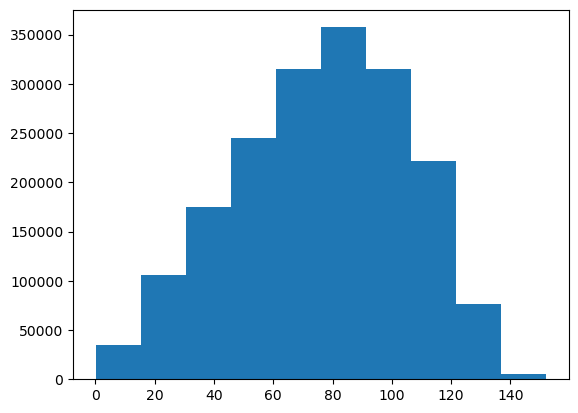

In [38]:
# plotted histogram of distance between customer and merchant 
plt.hist(data['distance_cust_merchant_km'])

In [39]:
#numerical_feature['distance_cust_merchant_km']

In [40]:
# 
ds_amt = data["distance_cust_merchant_km"].sort_values(ascending = False)
ds_amt.sort_values(ascending = False)



926894     152.119995
1562431    150.919998
216446     150.830002
161915     149.800003
252294     149.429993
              ...    
1526159      0.120000
42055        0.110000
273923       0.090000
556401       0.070000
381941       0.020000
Name: distance_cust_merchant_km, Length: 1852394, dtype: float32

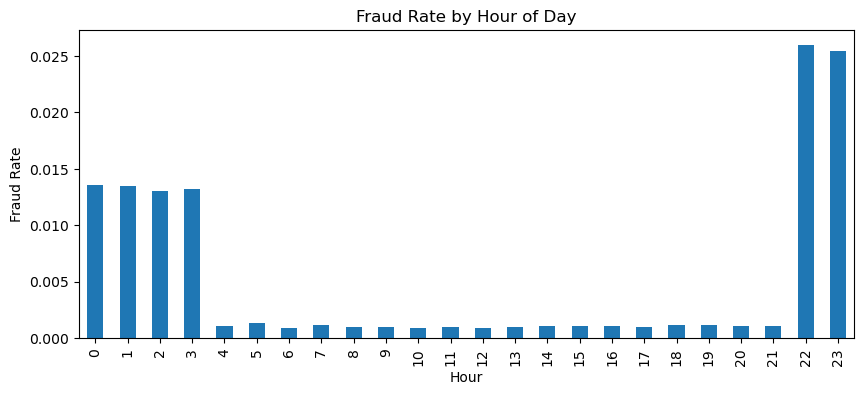

In [41]:
#For each hour of the day, it calculates what fraction of transactions are fraud.
fraud_by_hour = numerical_feature.groupby('tr_hour')['is_fraud'].mean()

plt.figure(figsize=(10,4))
fraud_by_hour.plot(kind='bar')
plt.title('Fraud Rate by Hour of Day')
plt.ylabel('Fraud Rate')
plt.xlabel('Hour')
plt.show()
#Fraud by Hour of Day


From above graph we can understand that during night hours fraud rate is high as compare to day time

In [42]:
# Fraud Rate, Count, and Transaction Volume by Hour of Day
summary_of_tr_hour = data.groupby('tr_hour').agg(
    total_txn=('is_fraud','count'),
    fraud_count=('is_fraud','sum'),
    fraud_rate=('is_fraud','mean')
)
summary_of_tr_hour.sort_values('fraud_rate', ascending=False)

,total_txn,fraud_count,fraud_rate
tr_hour,,,
22,95370,2481,0.026014
23,95902,2442,0.025463
0,60655,823,0.013569
1,61330,827,0.013484
3,60968,803,0.013171
2,60796,793,0.013044
5,60088,80,0.001331
7,60301,72,0.001194
18,94052,111,0.001180


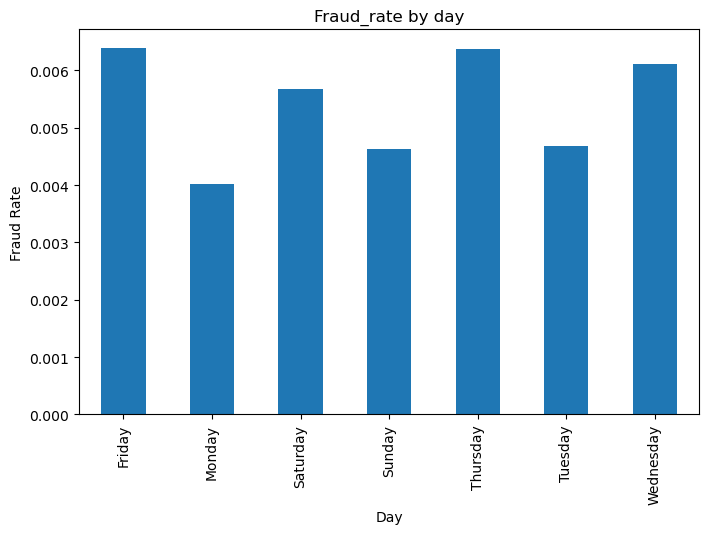

In [43]:
# fraud_rate by day name
fraud_by_day = data.groupby('tr_day_name')['is_fraud'].mean()
plt.figure(figsize =(8,5))
fraud_by_day.plot(kind='bar')
plt.title('Fraud_rate by day')
plt.ylabel('Fraud Rate')
plt.xlabel('Day')
plt.show()

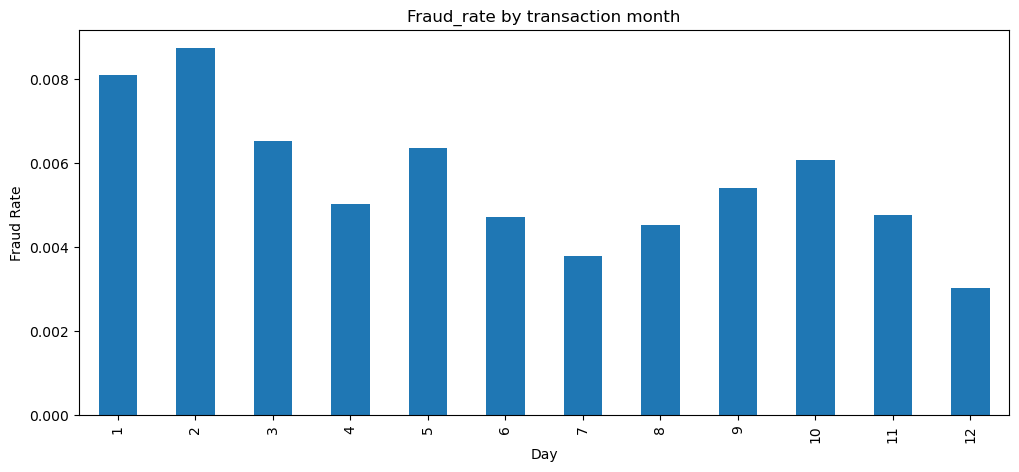

In [44]:
# fraud rate by month 
fraud_by_month = data.groupby('tr_month')['is_fraud'].mean()
plt.figure(figsize =(12,5))
fraud_by_month.plot(kind='bar')
plt.title('Fraud_rate by transaction month')
plt.ylabel('Fraud Rate')
plt.xlabel('Day')
plt.show()

In [45]:
numerical_feature = numerical_feature.drop(columns = ['cc_num','zip','tr_year','is_fraud','lat','long','merch_lat','merch_long'])

In [46]:
numerical_feature.columns

Index(['amt', 'city_pop', 'tr_month', 'tr_day', 'tr_hour', 'tr_minute', 'age',
       'outliers_amount'],
      dtype='object')

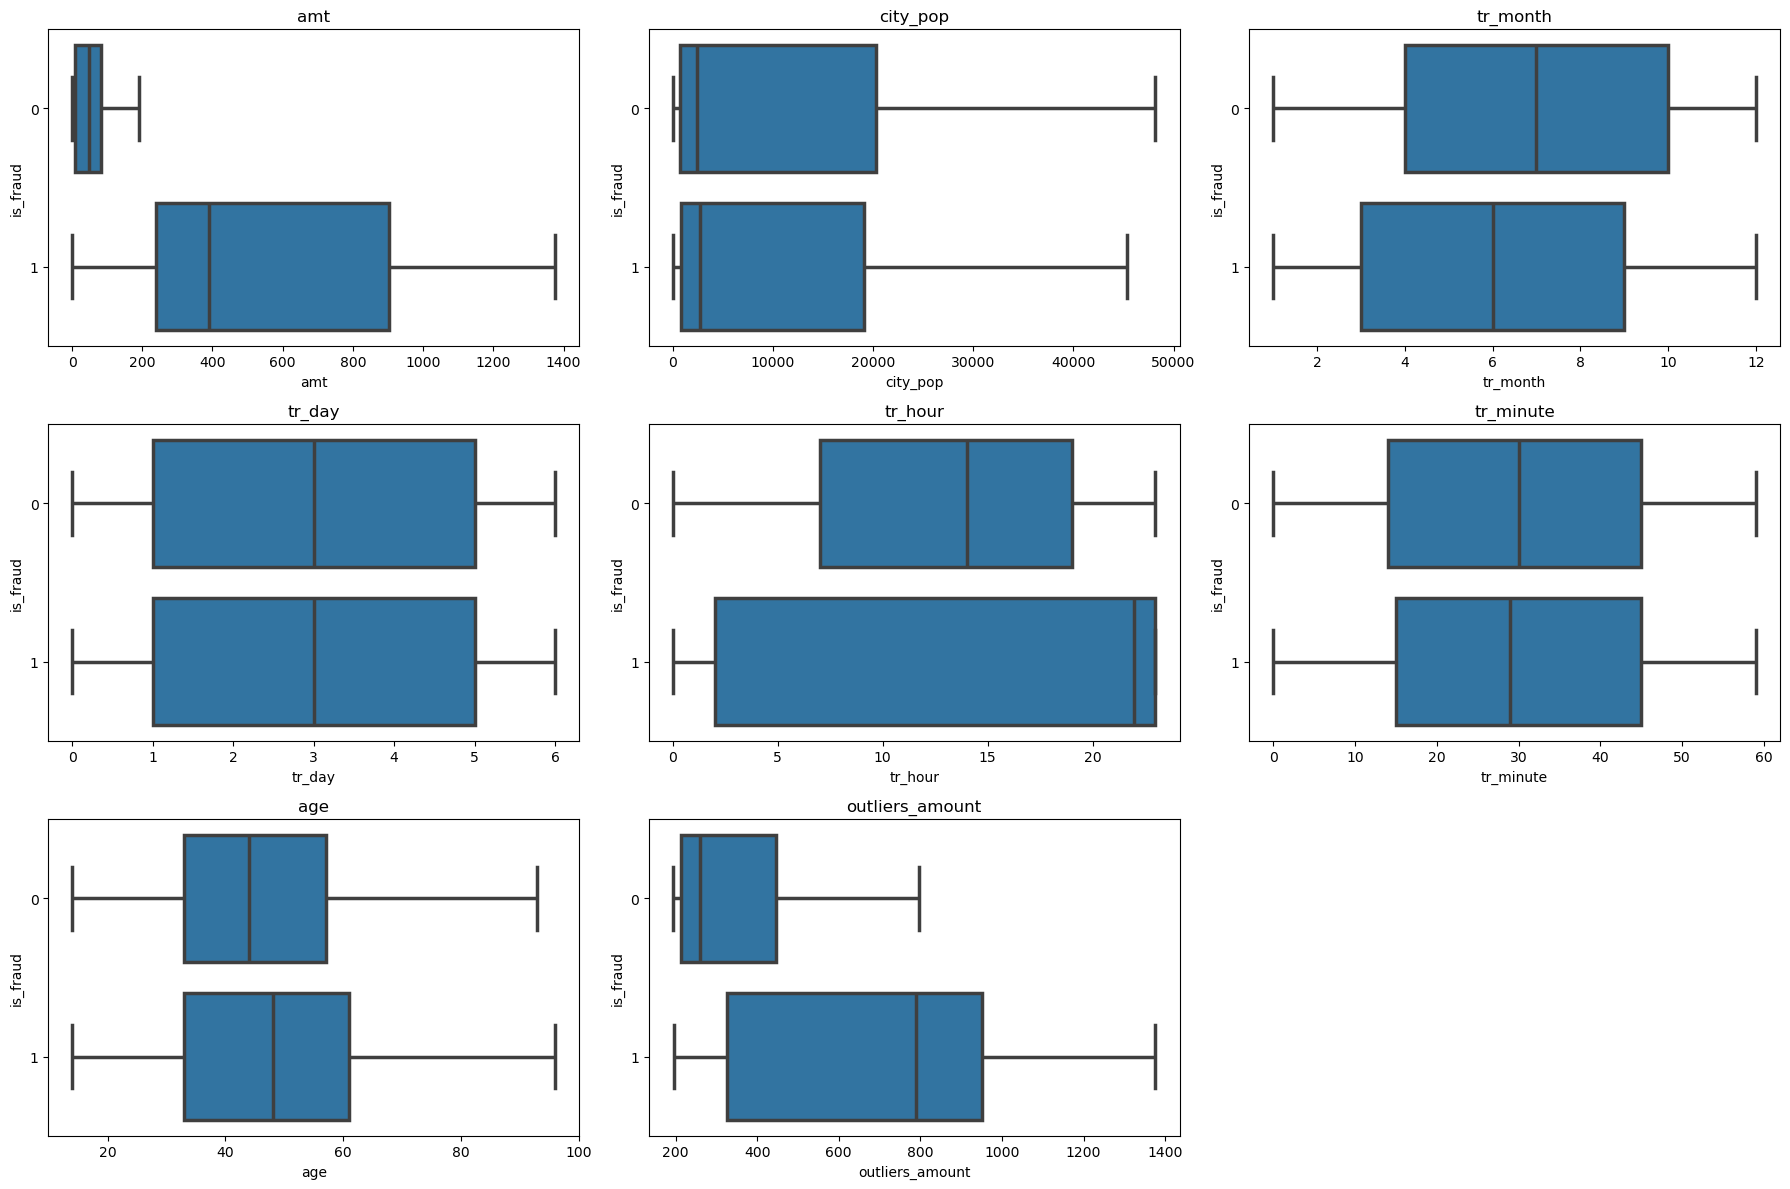

In [47]:
# box plot of all numerical features 
# Boxplots are best for continuous numeric data
import math

cols = numerical_feature.columns
n_cols = 3 # I want 3 columns in each row 
n_rows = math.ceil(len(cols) / n_cols) # ceil round up and floor round down we are using round up so that we have enough space for plot

plt.figure(figsize=(18, 4 * n_rows))

for i, c in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=data, x=c, y='is_fraud', orient='h',  linewidth=2.5, showfliers=False)
    plt.title(c)
    plt.tight_layout()

plt.show()

Boxplot analysis shows that transaction amount and outlier amount exhibit clear distributional shifts for fraud cases.

In [48]:
data = data.drop(columns = 'outliers_amount')

In [49]:
data['is_fraud'].value_counts(normalize=True) * 100

is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64

### 8) Categorical Feature Analysis
Explore fraud patterns across categories like gender, state, category, merchant, etc.


In [50]:
categorical_feature.columns

Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'trans_num', 'age_group', 'tr_day_name'],
      dtype='object')

In [51]:
categorical_feature['trans_num'].is_unique
# as it is unique so it works like id only it wont provide any insight so we can drop it

True

In [52]:
#categorical feature analysis
#dropped transaction number because it is unique 
categorical_feature = categorical_feature.drop(columns='trans_num')

In [53]:
data.groupby('category')['is_fraud'].agg(
    total_txn='count',
    fraud_txn='sum',
    fraud_rate='mean'
).sort_values('fraud_rate', ascending=False).head(10)

,total_txn,fraud_txn,fraud_rate
category,,,
shopping_net,139322,2219,0.015927
misc_net,90654,1182,0.013039
grocery_pos,176191,2228,0.012645
shopping_pos,166463,1056,0.006344
gas_transport,188029,772,0.004106
misc_pos,114229,322,0.002819
grocery_net,64878,175,0.002697
travel,57956,156,0.002692
personal_care,130085,290,0.002229


In [54]:
# groupby job 
 #  Group rows by the 'job' category #splits the data by each job title.['is_fraud'] 
 # focuses aggregations on the is_fraud column.
 # n='size'total rows per job,fraud_cnt='sum'=count of frauds per job, 
 # fraud_rate share of fraud, Sort jobs by highest fraud rate first
data.groupby('job')['is_fraud'].agg(n='size', fraud_cnt='sum', fraud_rate='mean').sort_values('fraud_rate', ascending=False)

,n,fraud_cnt,fraud_rate
job,,,
"Accountant, chartered",11,11,1.000000
Warehouse manager,7,7,1.000000
Careers adviser,15,15,1.000000
Solicitor,11,11,1.000000
Ship broker,7,7,1.000000
...,...,...,...
Health physicist,4374,3,0.000686
Contractor,4366,2,0.000458
"Engineer, communications",2190,0,0.000000


In [55]:
categorical_feature.columns

Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'age_group', 'tr_day_name'],
      dtype='object')

not able to plot merchant vs fraud rate percent so filter out number of trasaction > than average number of transaction on merchant level, got top 10 merchant with higher number of trasaction

In [56]:
# on main data, groupby by city and is_fraud on amount and counted fraud transaaction 
# computes fraud transaction counts per city, sorts them descending, and shows the top 20.
city_amt = data.groupby(["city", "is_fraud"])["amt"].agg("count")
city_amt


city                       is_fraud
Achille                    0            727
                           1             13
Acworth                    0           2912
                           1             13
Adams                      0            727
                                       ... 
Yellowstone National Park  1             12
Zaleski                    0           2183
                           1             12
Zavalla                    0           2186
                           1             12
Name: amt, Length: 1723, dtype: int64

In [57]:
#Show the top 20 merchants by number of fraudulent transactions.
# grupby data on merchant and is_fraud on amount and counted number of top 20 fraud count.
merchant_amt_df = data.groupby(["merchant", "is_fraud"])["amt"].agg("count")
merchant_amt_df = pd.DataFrame(merchant_amt_df).reset_index().sort_values("amt", ascending= False)
merchant_amt_df = merchant_amt_df[merchant_amt_df["is_fraud"]==1]
merchant_amt_df.columns = ["merchant", "is_fraud", "fraud_count"]
merchant_amt_df.head(20)
# sns.barplot(data=gender_amt_df, x= "gender",y= "amt", hue = "is_fraud")
# plt.xticks(rotation=90)
# plt.tight_layout()

,merchant,is_fraud,fraud_count
631,fraud_Kilback LLC,1,62
673,fraud_Kozey-Boehm,1,60
985,fraud_Rau and Sons,1,60
293,fraud_Doyle Ltd,1,57
1226,fraud_Terry-Huel,1,56
697,fraud_Kuhn LLC,1,55
141,fraud_Boyer PLC,1,55
854,"fraud_Moen, Reinger and Murphy",1,53
691,fraud_Kuhic LLC,1,53
617,fraud_Kiehn-Emmerich,1,53


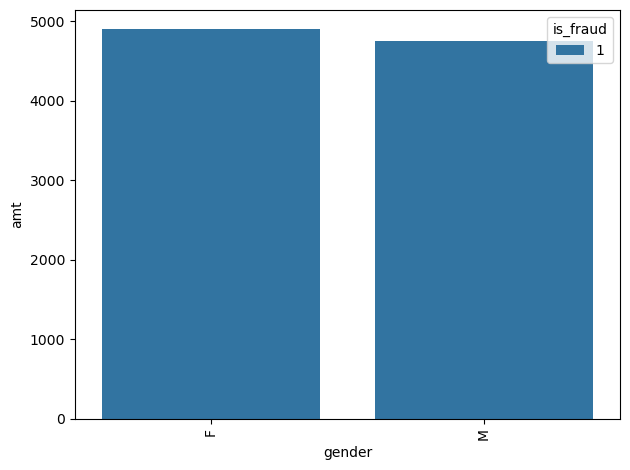

In [58]:
# Group by gender and fraud flag,on amt column then count transactions in each group
gender_amt_df = data.groupby(["gender", "is_fraud"])["amt"].agg("count")
gender_amt_df = pd.DataFrame(gender_amt_df).reset_index()
gender_amt_df = gender_amt_df[gender_amt_df["is_fraud"]==1]
sns.barplot(data=gender_amt_df, x= "gender",y= "amt", hue = "is_fraud")
plt.xticks(rotation=90)
plt.tight_layout()

In [59]:

# Group the data by gender and fraud flag, then compute the average transaction
gender_amt_df = data.groupby(["gender", "is_fraud"])["amt"].agg("mean")


In [60]:
gender_amt_df = pd.DataFrame(gender_amt_df).reset_index()
gender_amt_df

,gender,is_fraud,amt
0,F,0,67.916593
1,F,1,490.456538
2,M,0,67.329593
3,M,1,572.109998


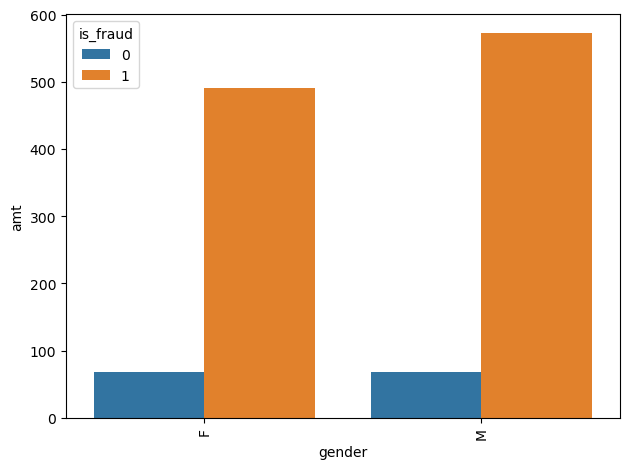

In [61]:
# average fraud trasaction by gender so here male fraud average trasaction amnt is 580 and female has 500.
sns.barplot(data=gender_amt_df, x= "gender",y= "amt", hue = "is_fraud")
plt.xticks(rotation=90)
plt.tight_layout()

In [62]:
#group by tr_year and is_fraud on amount and calculated average fraud amount on year wise
yr_amt_df = data.groupby(['tr_year', "is_fraud"])["amt"].agg("mean")
yr_amt_df = pd.DataFrame(yr_amt_df).reset_index()
yr_amt_df

,tr_year,is_fraud,amt
0,2019,0,67.654524
1,2019,1,530.234266
2,2020,0,67.648044
3,2020,1,531.164617


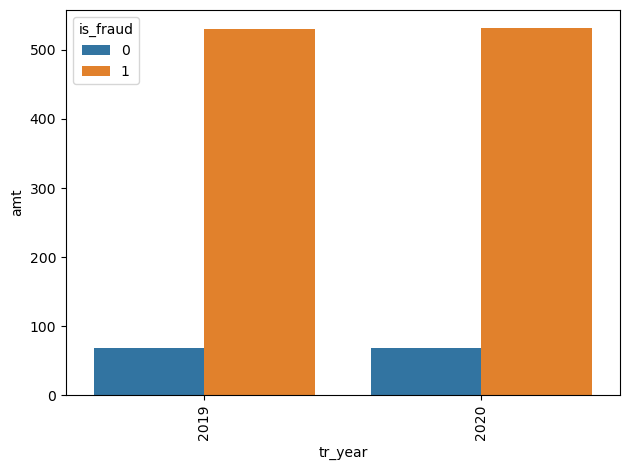

In [63]:
sns.barplot(data=yr_amt_df, x='tr_year' ,y= "amt", hue = "is_fraud")
plt.xticks(rotation=90)
plt.tight_layout()

In [64]:
# on data group by category and is_fraud on amount and calculate average fraud amount by each category.
cat_amt_df = data.groupby(["category", "is_fraud"])["amt"].agg("mean") # did try sum also

In [65]:
cat_amt_df = pd.DataFrame(cat_amt_df).reset_index()
cat_amt_df.head()

,category,is_fraud,amt
0,entertainment,0,63.181494
1,entertainment,1,504.794384
2,food_dining,0,50.884652
3,food_dining,1,120.678829
4,gas_transport,0,63.688542


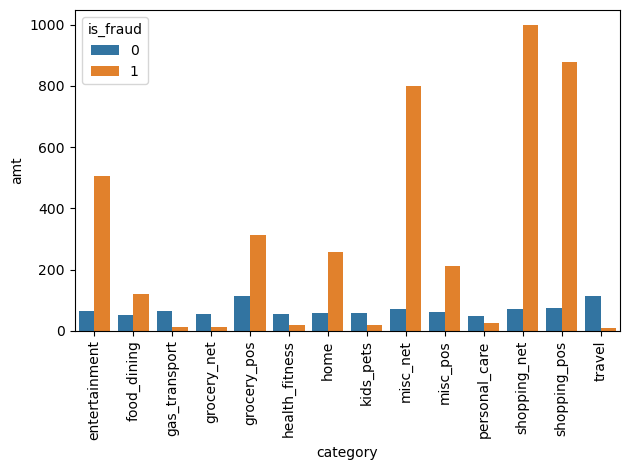

In [66]:
sns.barplot(data=cat_amt_df, x= "category",y= "amt", hue = "is_fraud")
plt.xticks(rotation=90)
plt.tight_layout()

In [67]:
# on data group by ctr_day_name and is_fraud on amount and calculate count of transaction  by each tr_day_name
day_amt_df = data.groupby(["tr_day_name", "is_fraud"])["amt"].agg("count")
day_amt_df = pd.DataFrame(day_amt_df).reset_index()
day_amt_df.head()

,tr_day_name,is_fraud,amt
0,Friday,0,213702
1,Friday,1,1376
2,Monday,0,367934
3,Monday,1,1484
4,Saturday,0,261734


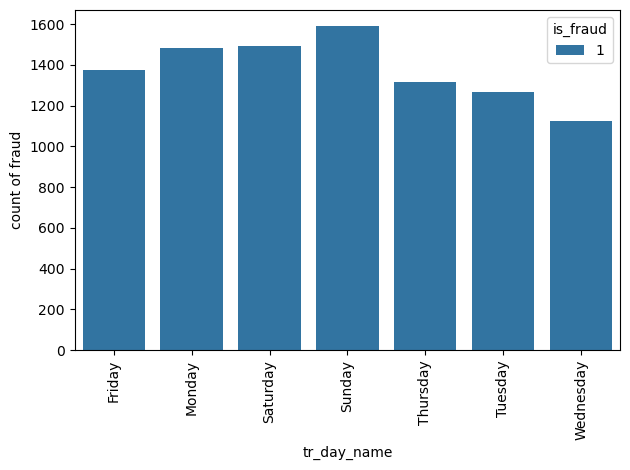

In [68]:
sns.barplot(data=day_amt_df[day_amt_df["is_fraud"]==1], x= "tr_day_name",y= "amt", hue = "is_fraud")
plt.xticks(rotation=90)
plt.ylabel("count of fraud")
plt.tight_layout()

In [69]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,78.599998
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,30.209999
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,108.209999
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,95.669998
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,77.559998


In [70]:
age_group_amt_df = data.groupby(["age_group", "is_fraud"])["amt"].agg("mean")
age_group_amt_df = pd.DataFrame(age_group_amt_df).reset_index()
age_group_amt_df.head()

,age_group,is_fraud,amt
0,adult,0,70.552145
1,adult,1,497.627089
2,senior,0,62.653935
3,senior,1,568.048514
4,teen,0,62.298210


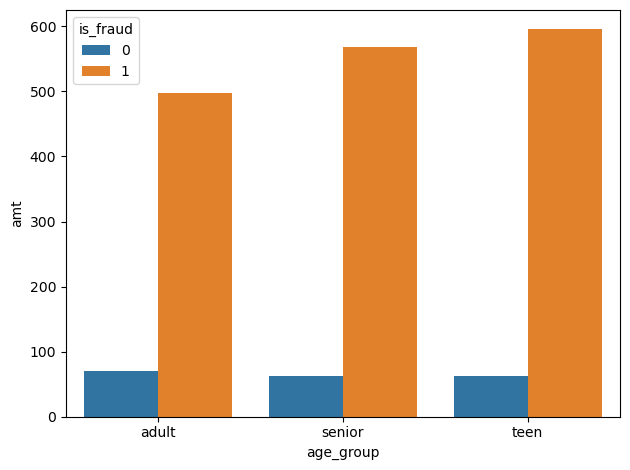

In [71]:
sns.barplot(data=age_group_amt_df, x= "age_group",y= "amt", hue = "is_fraud")
#plt.xticks(rotation=90)
plt.tight_layout()

In [72]:
#Fraud Rate for High-Amount Late-Night Transactions
temp_flag = (
    (data['amt'] > data['amt'].quantile(0.95)) &
    (data['tr_hour'].between(0, 5))
)

fraud_rate_interaction = data.groupby(temp_flag)['is_fraud'].mean()
fraud_rate_interaction

False    0.003944
True     0.114388
Name: is_fraud, dtype: float64

This interaction analysis shows that fraud risk increases significantly when high transaction amounts occur during late-night hours,
confirming that fraud patterns are driven by contextual feature interactions rather than individual features.

In [73]:
# Fraud-rate tables with counts 
def fraud_rate_table(df, col, top_n=10):
    out = df.groupby(col)['is_fraud'].agg(total_txn='count', fraud_txn='sum', fraud_rate='mean')\
            .sort_values(['fraud_rate','fraud_txn'], ascending=False)
    return out.head(top_n)

for col in ['category', 'gender', 'state']:
    if col in data.columns:
        print('\n===', col, '===')
        display(fraud_rate_table(data, col, top_n=10)) 
        
# display tells Jupyter:show it as a proper table with rows, columns, alignment, scroll, etc.

Baseline fraud rate: 0.005210014716091717

=== category ===


,total_txn,fraud_txn,fraud_rate
category,,,
shopping_net,139322,2219,0.015927
misc_net,90654,1182,0.013039
grocery_pos,176191,2228,0.012645
shopping_pos,166463,1056,0.006344
gas_transport,188029,772,0.004106
misc_pos,114229,322,0.002819
grocery_net,64878,175,0.002697
travel,57956,156,0.002692
personal_care,130085,290,0.002229



=== gender ===


,total_txn,fraud_txn,fraud_rate
gender,,,
M,837645,4752,0.005673
F,1014749,4899,0.004828



=== state ===


,total_txn,fraud_txn,fraud_rate
state,,,
DE,9,9,1.000000
RI,745,15,0.020134
AK,2963,50,0.016875
OR,26408,197,0.007460
NH,11727,79,0.006737
VA,41756,273,0.006538
TN,24913,159,0.006382
NE,34425,216,0.006275
MN,45433,280,0.006163


In [74]:
#data.to_csv('eda_dataset.csv', index = False)
data.to_csv('eda_dataset_final_version_updated_last_withdate_time.csv', index = False)


## Final EDA Summary
Below is a concise summary you can use directly in interviews / documentation.


## Summary (EDA Takeaways)
**What I checked:**
- Dataset shape, columns, and basic sanity checks.
- Target class imbalance (fraud % vs non-fraud %).
- Time-based feature engineering from transaction timestamp.
- Amount distribution and outlier behavior.
- Numerical and categorical feature patterns w.r.t. fraud.

**Key findings (high level):**
- The dataset is **highly imbalanced**, so accuracy is not meaningful; PR-AUC/Recall are more informative.
- Fraud behavior shows **distinct patterns** across **time** and **transaction amount**.
- Some categorical segments (e.g., category/merchant/city/state) can show higher fraud concentration.

**How EDA guided modeling:**
- Used **imbalance-aware metrics** (PR-AUC, Recall) and **sampling/imbalance handling** during modeling.
- Used engineered time features and handled skew/outliers in amount where required.
- Final decision threshold can be tuned to prioritize fraud catch rate.


## Aggregated Fraud-Rate Tables
These tables help avoid small-sample bias by showing **total transactions**, **fraud transactions**, and **fraud rate** together.
